In [1]:
print('In The Name Of Allah The Most Gracious The Most Merciful')

In The Name Of Allah The Most Gracious The Most Merciful


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix, 
                            f1_score, recall_score, classification_report, 
                            roc_curve, auc, precision_recall_curve, roc_auc_score)

In [3]:
# Load the dataset
df = pd.read_csv('housing.csv')

In [4]:
def data_summary(df):
    print("📌 Dataset Shape:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n📌 Column-wise Missing Values:")
    missing = df.isnull().sum()
    if missing.any():
        print(missing[missing > 0])
    else:
        print("✅ No missing values found.")
    
    print("\n📌 Duplicate Rows:")
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"⚠️ Found {duplicate_count} duplicate rows.")
    else:
        print("✅ No duplicate rows found.")
    
    print("\n📌 Basic Info:")
    print(df.info())

# Call it
data_summary(df)

📌 Dataset Shape:
Rows: 20640, Columns: 10

📌 Column-wise Missing Values:
total_bedrooms    207
dtype: int64

📌 Duplicate Rows:
✅ No duplicate rows found.

📌 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [5]:
# Display statistical summary
print("📊 Statistical Summary of Numerical Features:")
df.describe().T.style.background_gradient(cmap='twilight_shifted')

📊 Statistical Summary of Numerical Features:


,count,mean,std,min,25%,50%,75%,max
longitude,20640.000000,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20640.000000,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
housing_median_age,20640.000000,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20640.000000,2635.763081,2181.615252,2.000000,1447.750000,2127.000000,3148.000000,39320.000000
total_bedrooms,20433.000000,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20640.000000,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
households,20640.000000,499.539680,382.329753,1.000000,280.000000,409.000000,605.000000,6082.000000
median_income,20640.000000,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
median_house_value,20640.000000,206855.816909,115395.615874,14999.000000,119600.000000,179700.000000,264725.000000,500001.000000


In [6]:
# identify the  numeric columns
numeric_df = df.select_dtypes(include='number')

# Show only highly skewed columns
print("\nSkewd Columns")
skewness = numeric_df.skew().sort_values(ascending=False)
print(skewness)

# Show columns with skewness > 1 or < -1 (highly skewed)
print("\nHighly Skewed Columns:")
print(skewness[abs(skewness) > 1])



Skewd Columns
population            4.935858
total_rooms           4.147343
total_bedrooms        3.459546
households            3.410438
median_income         1.646657
median_house_value    0.977763
latitude              0.465953
housing_median_age    0.060331
longitude            -0.297801
dtype: float64

Highly Skewed Columns:
population        4.935858
total_rooms       4.147343
total_bedrooms    3.459546
households        3.410438
median_income     1.646657
dtype: float64


In [7]:
print("\n🚨 Potential Outliers (using Z-score > 3):")
from scipy.stats import zscore
z_scores = df.select_dtypes(include='number').apply(zscore)
outliers = (abs(z_scores) > 3).sum()
print(outliers)


🚨 Potential Outliers (using Z-score > 3):
longitude               0
latitude                0
housing_median_age      0
total_rooms           373
total_bedrooms          0
population            342
households            363
median_income         345
median_house_value      0
dtype: int64


## Plot The Historgram

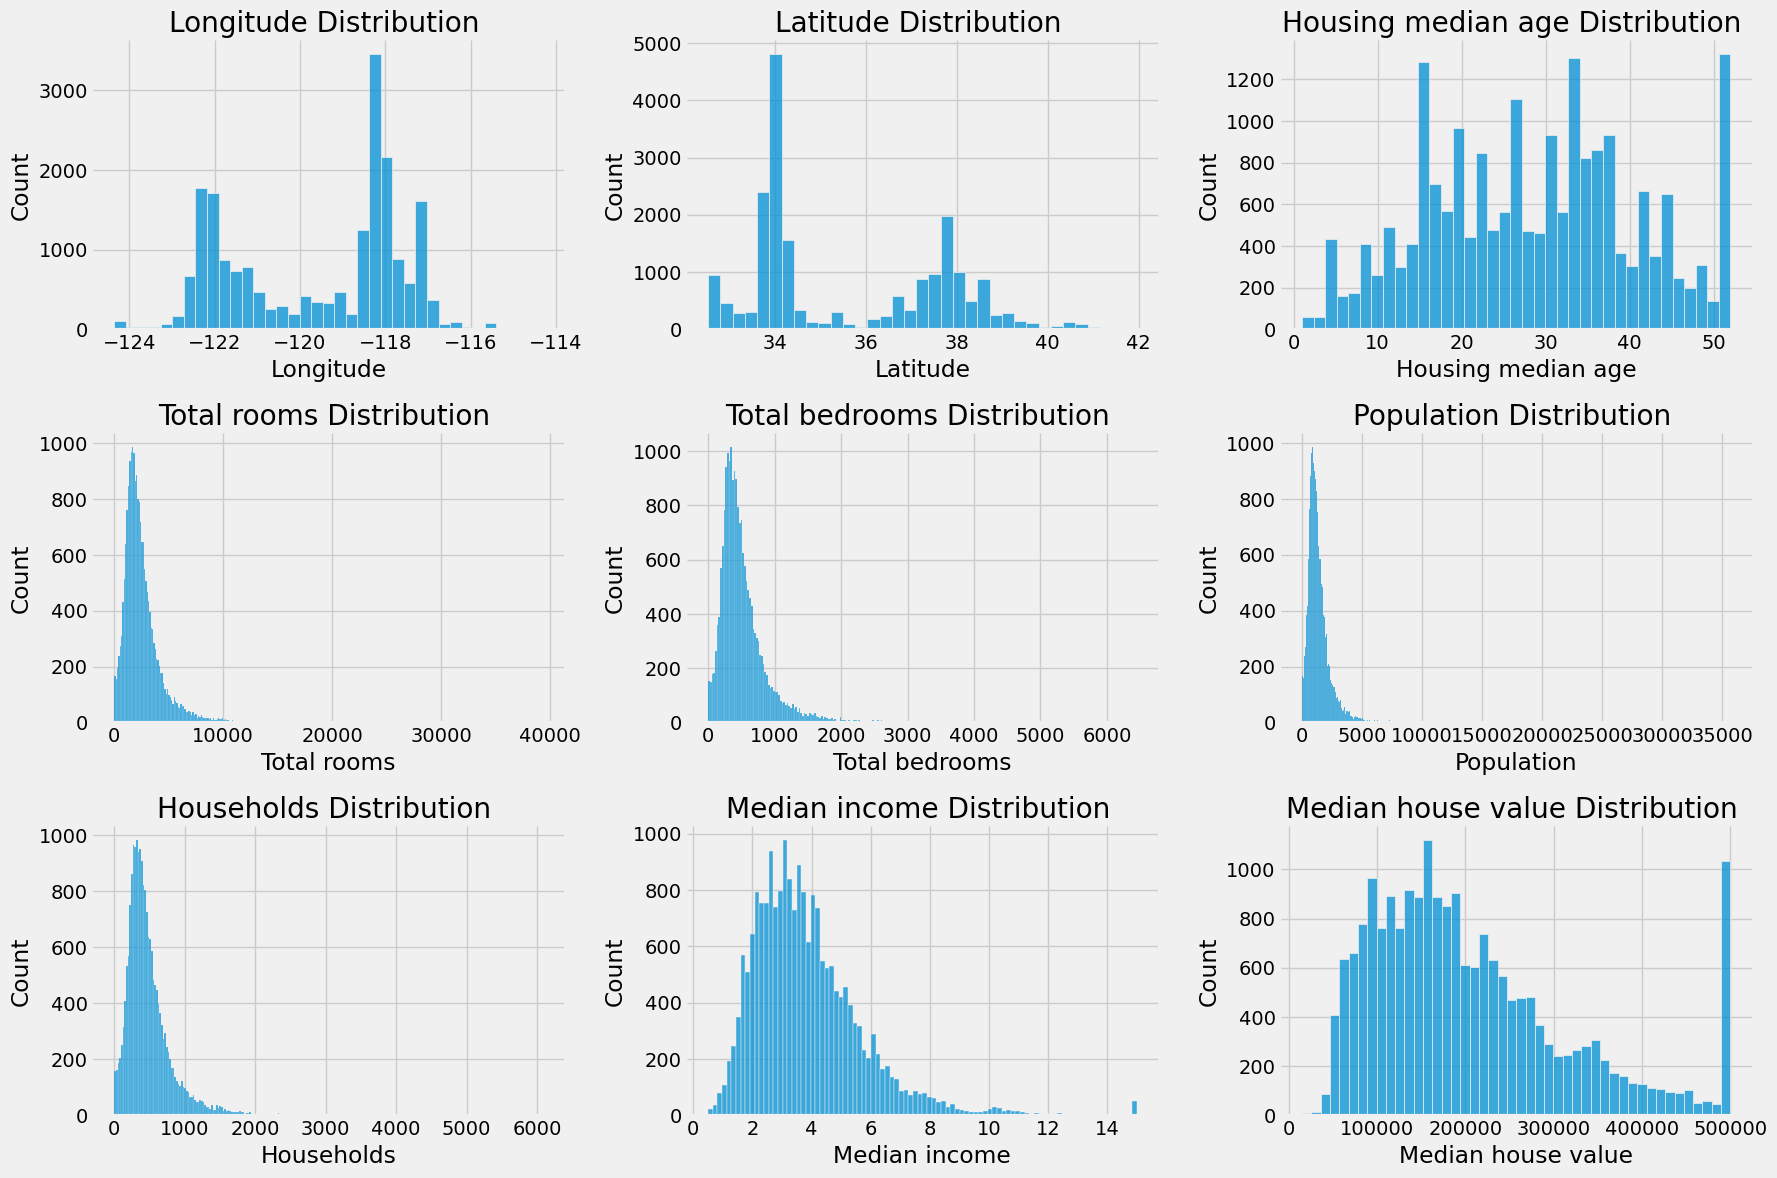

<Figure size 640x480 with 0 Axes>

In [8]:
# Identify numerical features
feature = df.select_dtypes(include='number').columns.tolist()

# Exclude the "heart_disease" target column
numeric_features = [col for col in feature if col != 'ocean_proximity']

# Create subplot grid
num_cols = len(numeric_features)
n_rows = (num_cols + 2) // 3  # 3 columns per row
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Plot each numeric feature
for i, col in enumerate(numeric_features):
    sns.histplot(data=df,x=col,palette='Set3', ax=axes[i])
    axes[i].set_title(f"{col.replace('_',' ').capitalize()} Distribution ")
    axes[i].set_xlabel(f"{col.replace('_',' ').capitalize()}")
    axes[i].set_ylabel('Count')
    sns.despine(ax=axes[i], top=True, right=True, left=True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.savefig("Numeric Feature Distribution of Housing.png")

## ✨ Handle missing values

In [9]:
df['total_bedrooms'] = df.groupby('ocean_proximity')['total_bedrooms'].transform(lambda x : x.fillna(x.median()))

## ✨ Fix Highly Skewed Columns

``` python
skewed_columns = ['population','total_rooms','total_bedrooms','households','median_income']
for col in skewed_columns:
    df[col + '_log'] = np.log1p(df[col])
    ```

## ✨  Handle Outliers

In [10]:
for col in ['population', 'total_rooms', 'households', 'median_income']:
    q = df[col].quantile(0.99)
    df[col] = np.where(df[col]>q,q,df[col])

## Income Scale Clarification

``` python 
df['median_income_dollar'] = df['median_income'] * 10_000 
```

## Correlation matrix and Heatmap

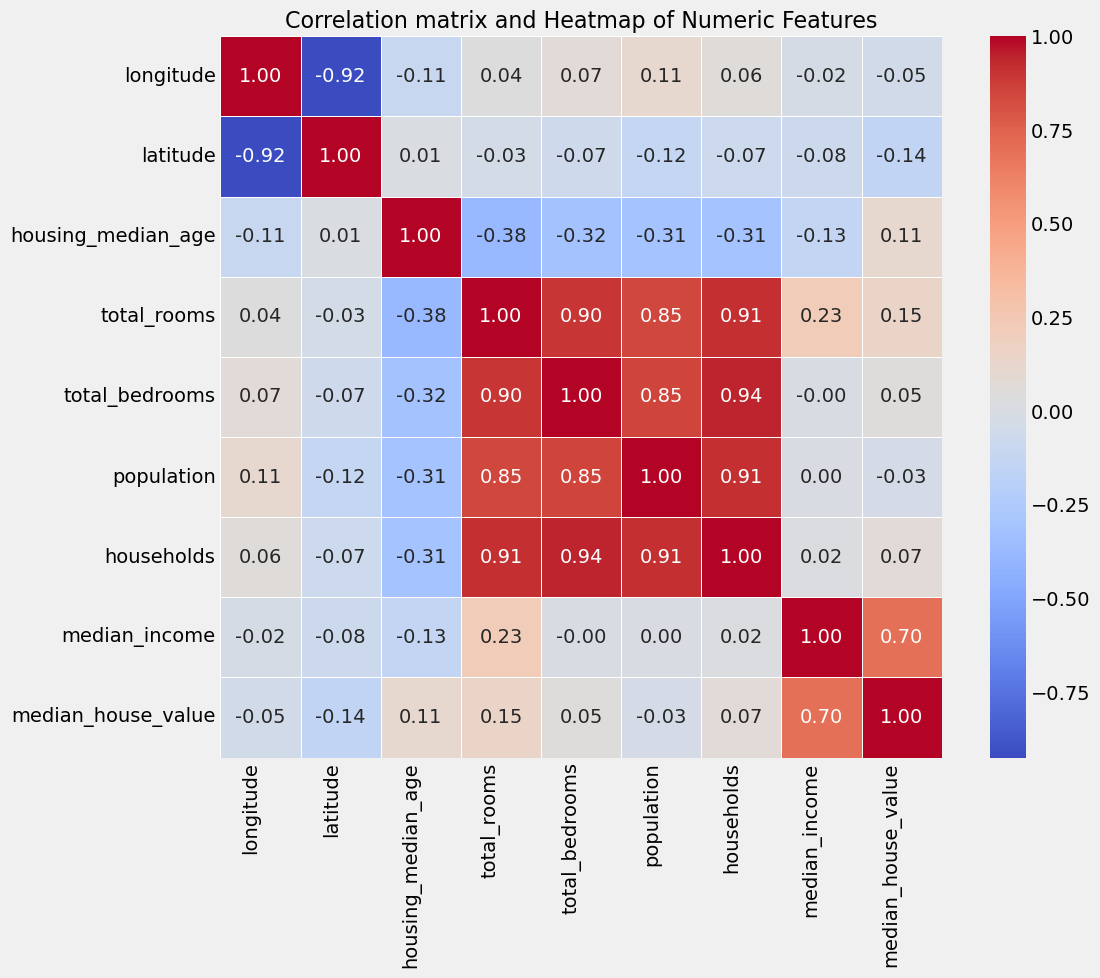

In [11]:
# Select only numeric features (including target for reference)
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

plt.title("Correlation matrix and Heatmap of Numeric Features", fontsize=16)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# plt.savefig("Correlation matrix and Heatmap of Numeric Features.png")

 need stratified splitting, Because:

✅ There is a __strong predictor__ (`median_income`)

✅ That predictor is __skewed__

✅ It has a __strong correlation__ with the target

✅ You want the __train and test sets to have the same distribution__ of that predictor

In [12]:
df['income_cat'] = pd.cut(
    df['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]


## ✨ Stratify Based on Binned Income

drop `income_cat`

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


In [14]:
housing = strat_train_set.copy()

## Spatial Distribution

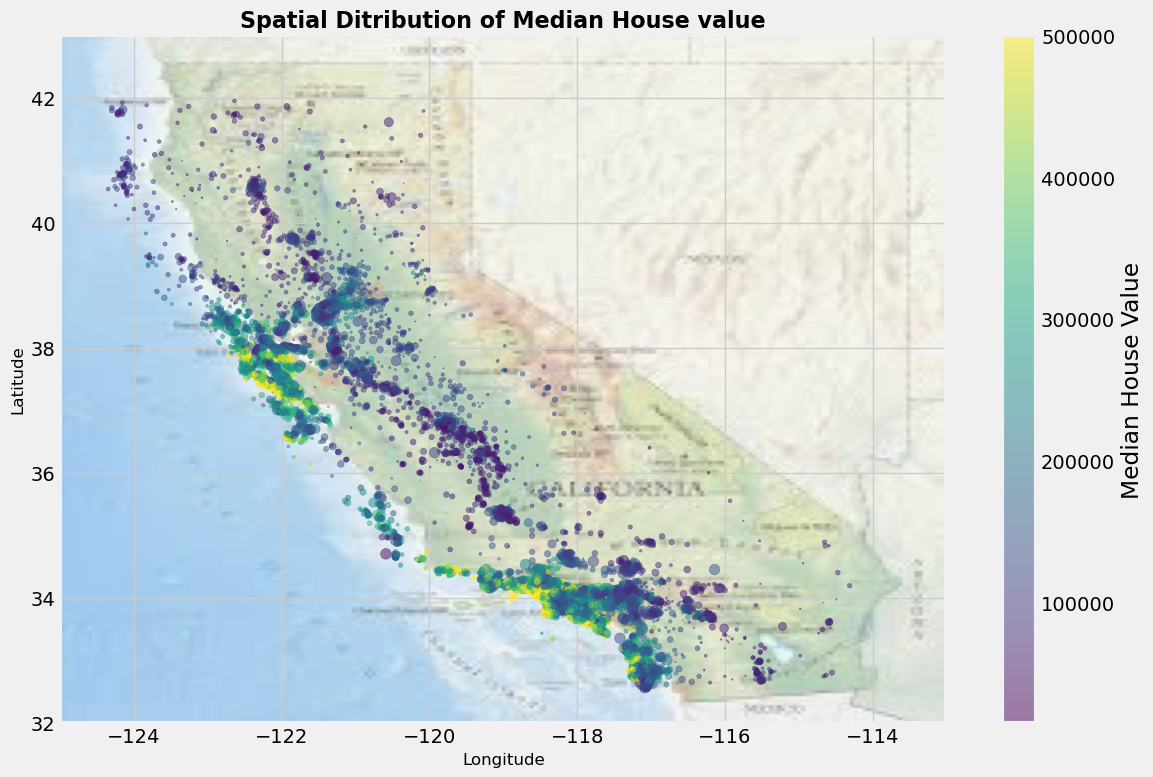

In [15]:
from PIL import Image

# Load using Pillow
img = Image.open("california-map2.jpeg")

# set up the figure
plt.figure(figsize=(12,8))

# adjust extent to match long/lat range of california
# tweak the value based on the dataset
img_array = np.array(img)

# Plot it
plt.imshow(img_array, extent=[-125, -113, 32, 43], aspect='auto', alpha=0.6)
# Scatter plot
scatter = plt.scatter(
    housing['longitude'],
    housing['latitude'],
    c=housing['median_house_value'],
    cmap='viridis',
    s=housing['population']/100,
    alpha=0.5
)

# colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Median House Value')

# add title and labels
plt.title('Spatial Ditribution of Median House value',fontsize=16,fontweight='bold')
plt.xlabel('Longitude',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.tight_layout()
plt.show()

### ✅ Summary:

> The visualization reveals that **California’s housing market is heavily influenced by geography**. The **highest house prices** are concentrated in **urban coastal areas** such as San Francisco and Los Angeles, which are also **highly populated**. In contrast, **inland and rural areas** show **lower house values and population density**. This spatial disparity highlights the **significance of location** in determining housing costs, often driven by economic activity, job markets, and proximity to coastlines.

---


## Feature Engineering

In [16]:
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']

In [17]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']

In [18]:
housing['population_per_household'] = housing['population'] / housing['households']

In [19]:
housing_num = housing.select_dtypes(include='number')
housing_num.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.694836
total_rooms                 0.149227
rooms_per_household         0.145676
housing_median_age          0.114146
households                  0.068671
total_bedrooms              0.047853
population_per_household   -0.025621
population                 -0.031495
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_rooms         -0.230756
Name: median_house_value, dtype: float64

## 📊 Population Distribution by Ocean Proximity (with Median House Values)

### Create Pie chart and shows:

- How much __population__ lives in each proximity zone (via slice size).
- What’s the __average housing cost__ in that zone (via label).

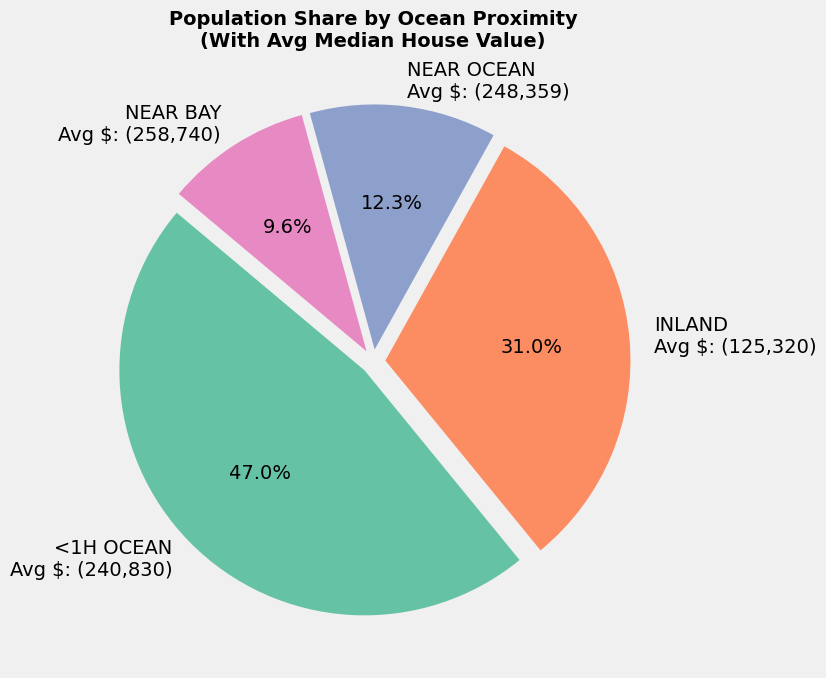

<Figure size 640x480 with 0 Axes>

In [20]:
# Group by ocean_proximity
grouped = housing.groupby('ocean_proximity').agg({
    'population': 'sum',
    'median_house_value': 'mean'
}).sort_values(by='population', ascending=False)

# Compute percentage share
grouped['percentage'] = (grouped['population'] / grouped['population'].sum()) * 100

# Filter out categories with < 1% population share (e.g., ISLAND)
filtered = grouped[grouped['percentage'] >= 1]

# Data for pie chart
labels = filtered.index
sizes = filtered['population']
avg_house_values = grouped['median_house_value']

# Format labels to include average house value
formatted_labels = [
    f"{label}\nAvg $: ({int(avg_val):,})" 
    for label, avg_val in zip(labels, avg_house_values)
]

# Plot
plt.figure(figsize=(10, 7))
plt.pie(
    sizes,
    labels=formatted_labels,
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', len(labels)),
    explode=[0.05]*len(labels),
    startangle=140
)
plt.title("Population Share by Ocean Proximity\n(With Avg Median House Value)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('pie chart of Population Share by Ocean Proximity.png')


### 📊 Interpretation

The pie chart shows that the majority of California’s population lives **less than one hour from the ocean (`<1H OCEAN`)**, followed by those living **inland**. These two categories dominate the chart, indicating that both **coastal access** and **inland affordability** are major factors in where people settle.

* **Coastal areas** (like `NEAR OCEAN` and `NEAR BAY`) have smaller population shares but often align with **higher median house values**, suggesting premium real estate zones.
* The **"ISLAND"** category is not shown due to its extremely low population share (less than 1%).

> *This visualization highlights the population clustering around both affordable inland areas and economically strong coastal zones.*




### One Hot Encoding ```ocean_proximity``` using ```ColumnTransformer``` inside a pipeline

``` python
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_feature = housing.select_dtypes(include='object').columns.tolist()
num_feature = housing.select_dtypes(include='number').columns.tolist()

# create the ColumnTransformer
preprocessor = ColumnTransformer([
    ('num',StandardScaler(),num_feature),
    ('cat',OneHotEncoder(handle_unknown='ignore'),cat_feature)
])

# fir and transform 
housing_prepared = preprocessor.fit_transform(housing) # return fully processed numpy array

# convert to the datframe
# Get encoded column names
cat_encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_feature)
all_cols = list(num_feature) + list(cat_encoded_cols)

# Convert to DataFrame
housing_df = pd.DataFrame(housing_prepared, columns=all_cols, index=housing.index)
```

**domain-specific feature engineering**
  Coulmns such as:
  - `bedrooms_per_rooms`,`rooms_per_household`,`population_per_houshold` __requires custom transformations__.

❌ __Why Built-in Transformers Don’t Work Here__

Built-in transformers like ```StandardScaler```, ```OneHotEncoder```, or ```SimpleImputer```:

- __Do not create new columns__.
- __Cannot compute ratios or custom logic__ based on multiple features.

That’s where you must __define a custom transformer__ to make these engineered features reusable and pipeline-compatible.

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

## Custom Transformation for Domain-Specific Ratios

``` python
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        X = X.copy()
        rooms_per_household = X['total_rooms'] / X['households']
        population_per_household = X['population'] / X['households']
        
        result = X.copy()
        result['rooms_per_household'] = rooms_per_household
        result['population_per_household'] = population_per_household
        
        if self.add_bedrooms_per_room:
            result['bedrooms_per_rooms'] = X['total_bedrooms'] / X['total_rooms']
        
        return result
```

``` python
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col + '_log'] = np.log1p(X[col])
        return X
```

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from custom_transformers import LogTransformer, CombinedAttributesAdder

#  Detect numeric and categorical columns
num_features = housing.select_dtypes(include='number').columns.tolist()
cat_features = housing.select_dtypes(include='object').columns.tolist()
log_features = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

# Build numeric pipeline
num_pipeline = Pipeline([
    ('log_transform', LogTransformer(log_features)),
    ('attribs_adder', CombinedAttributesAdder()),           # Add new domain-specific features
    ('imputer', SimpleImputer(strategy="median")),          # Fill missing values
    ('scaler', StandardScaler())                            # Scale the features
])

# 4. Full preprocessing pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features)
])

# 5. Apply the pipeline to the data
housing_prepared = full_pipeline.fit_transform(housing) # return array

log_cols = [col + '_log' for col in log_features]  # 5 log-transformed columns
domain_cols = ['rooms_per_household', 'population_per_household', 'bedrooms_per_rooms']

# encoded column name
cat_encoder = full_pipeline.named_transformers_['cat']
cat_col_names = cat_encoder.get_feature_names_out(cat_features)

# Get the numeric columns that were not log-transformed
non_log_num_cols = [col for col in num_features if col not in log_features]

# Combine all numeric output columns
numeric_output_cols = log_cols + domain_cols + non_log_num_cols

all_feature_names = numeric_output_cols + list(cat_col_names) + log_features

# Debug check
print("Expected columns:", len(all_feature_names))  # Should be 21
print("Prepared data shape:", housing_prepared.shape)  # Should be (16512, 21)


Expected columns: 21
Prepared data shape: (16512, 21)


In [23]:
housing_df = pd.DataFrame(housing_prepared, columns=all_feature_names)


## ✅ **Summary: Custom Transformers & Preprocessing Pipelines in scikit-learn**

### 🔹 1. **Understood the Need for Custom Transformers**

* Built-in transformers like `StandardScaler` and `OneHotEncoder` work for generic tasks.
* But **domain-specific logic** (like `population_per_household`) **requires custom transformers**.
* Custom transformers:

  * Allow you to create **new features**.
  * Are reusable and **pipeline-friendly**.
  * Prevent **data leakage** when used correctly inside `Pipeline`.

---

### 🔹 2. **Identified Domain-Specific Features in California Housing Dataset**

You engineered new columns such as:

* `rooms_per_household = total_rooms / households`
* `population_per_household = population / households`
* `bedrooms_per_rooms = total_bedrooms / total_rooms`

These are not raw columns — they require custom logic to generate.

---

### 🔹 3. **Built a Complete Preprocessing Pipeline**

You successfully created:

* A **numeric pipeline** that:

  * Adds new domain-specific features
  * Fills missing values (`SimpleImputer`)
  * Scales data (`StandardScaler`)
* A **column transformer** that:

  * Handles numeric columns with the numeric pipeline
  * Handles categorical columns with `OneHotEncoder`

---

### 🔹 4. **Converted the Final Transformed Output into a Clean DataFrame**

* Extracted encoded categorical column names using:

  ```python
  get_feature_names_out(cat_features)
  ```
* Manually combined original numeric + new engineered + encoded category columns.
* Used:

  ```python
  pd.DataFrame(prepared_data, columns=all_columns)
  ```

  to get a proper, labeled dataset.

---

### ✅ You Now Know:

| Skill                                        | Status |
| -------------------------------------------- | ------ |
| Writing custom transformers                  | ✅ Done |
| Building full pipelines                      | ✅ Done |
| Handling numeric + categorical data          | ✅ Done |
| Avoiding data leakage                        | ✅ Done |
| Converting transformed output into DataFrame | ✅ Done |

---



# Model training and Evaluation

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
# create the model
model = LinearRegression()
model.fit(housing_prepared,housing_labels)

# predict the model on some data
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]

prepared_data = full_pipeline.transform(some_data)

In [26]:
print("Prediction",model.predict(prepared_data))
print("Actual Labels\n", some_labels)

Prediction [ 81069.92138273 308340.37811083 166494.6543492  207597.98374598
 239463.9527551 ]
Actual Labels
 12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64


## Model Benchmarking Framework or Model Comparison Pipeline.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Store model performance
model_performance = {}

# Loop through models
for name, model in models.items():
    model.fit(housing_prepared, housing_labels)
    predictions = model.predict(housing_prepared)

    mse = mean_squared_error(housing_labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(housing_labels, predictions)
    r2 = r2_score(housing_labels, predictions)

    # Store rounded results
    model_performance[name] = {
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R²": round(r2, 4)
    }

# Convert to DataFrame
performance_df = pd.DataFrame(model_performance).T.sort_values(by="RMSE")

# Display nicely
print("🔍 Model Performance Table:")
display(performance_df)

🔍 Model Performance Table:


,MSE,RMSE,MAE,R²
Decision Tree,0.000000e+00,0.00,0.00,1.0000
Random Forest,3.485358e+08,18669.11,12083.99,0.9740
XGBoost,6.945823e+08,26354.93,18621.02,0.9481
HistGradientBoosting,1.569551e+09,39617.57,27096.32,0.8827
Gradient Boosting,2.573368e+09,50728.37,35191.07,0.8078
Linear Regression,4.244704e+09,65151.39,47029.95,0.6829


## Visualise the Model Performance table

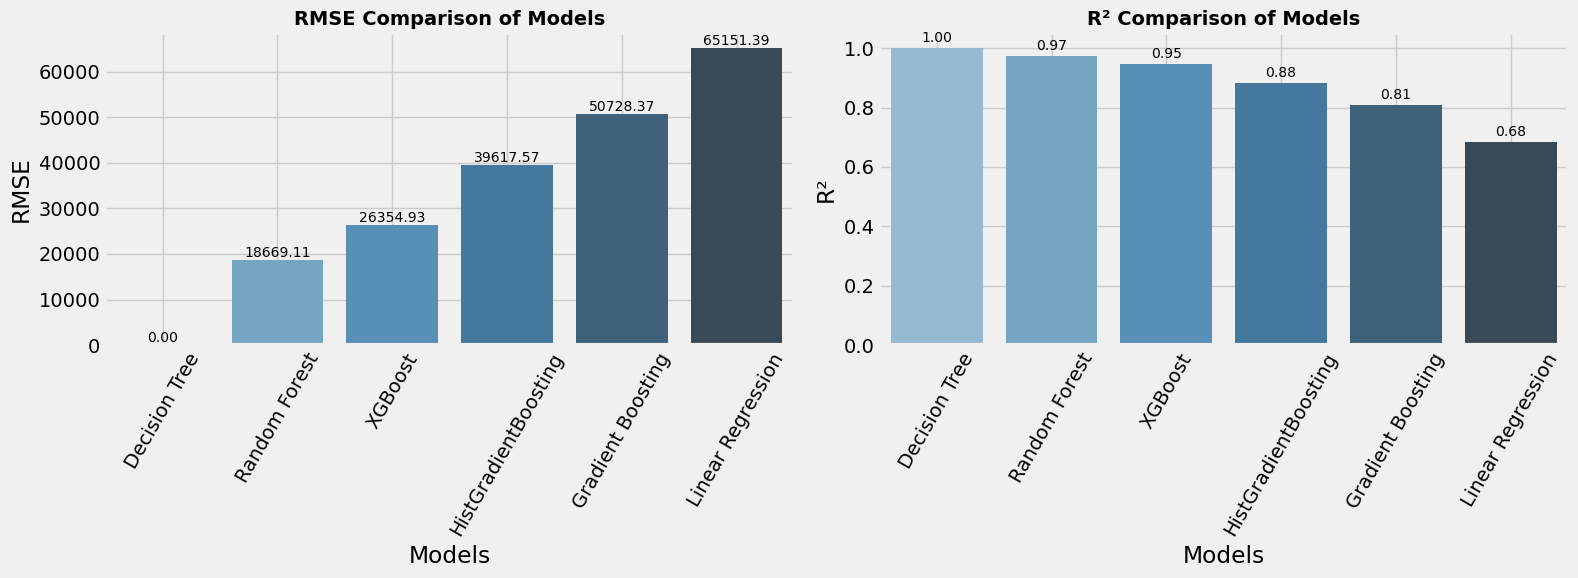

<Figure size 640x480 with 0 Axes>

In [28]:
# 1. Get model names and scores
models = list(model_performance.keys())
rmse_score = [model_performance[m]['RMSE'] for m in models]
r2_scores = [model_performance[m]['R²'] for m in models]

# 2. Sort by RMSE
sorted_indices = np.argsort(rmse_score)
sorted_models = [models[i] for i in sorted_indices]
sorted_rmse = [rmse_score[i] for i in sorted_indices]
sorted_r2 = [r2_scores[i] for i in sorted_indices]

# 3. Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot RMSE ---
sns.barplot(x=sorted_models, y=sorted_rmse, palette="Blues_d", ax=axes[0])
axes[0].set_title("RMSE Comparison of Models", fontsize=14, fontweight='bold')
axes[0].set_ylabel("RMSE")
axes[0].set_xlabel("Models")
axes[0].tick_params(axis='x', rotation=60)
axes[0].grid(True)

# Add value labels on top
for i, v in enumerate(sorted_rmse):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# --- Plot R² ---
sns.barplot(x=sorted_models, y=sorted_r2, palette="Blues_d", ax=axes[1])
axes[1].set_title("R² Comparison of Models", fontsize=14, fontweight='bold')
axes[1].set_ylabel("R²")
axes[1].set_xlabel("Models")
axes[1].tick_params(axis='x', rotation=60)
axes[1].grid(True)

# Add value labels on top
for i, v in enumerate(sorted_r2):
    axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('Model comparison.png')

## 📊 Model Comparison: RMSE Evaluation

We evaluated six different regression models on the California housing dataset. Below is a summary of the RMSE (Root Mean Squared Error) for each model:

- **Random Forest**: 18,669  
- **XGBoost**: 26,355  
- **HistGradientBoosting**: 39,618  
- **Gradient Boosting**: 50,728  
- **Linear Regression**: 65,151  
- **Decision Tree**: ⚠️ 0 (Likely overfitting or evaluated on training data)

---

### 🔍 Key Insights

- ✅ **Random Forest** is the best-performing model with the lowest RMSE (~18.7K), indicating strong predictive power and generalization.
- 🥈 **XGBoost** also performed well (~26.3K RMSE), and is a close second with excellent accuracy.
- ⚠️ **Decision Tree** reported an RMSE of 0, which strongly suggests it was evaluated on the training set — likely overfitting and should be re-evaluated on the test set.
- 📉 **Linear Regression** had the highest RMSE (~65K), showing it's too simple for this non-linear housing price prediction task.
- 📈 Boosting models (XGBoost, HistGB, Gradient Boosting) performed better than Linear Regression but were slightly behind Random Forest.

---

### ✅ Conclusion

Random Forest should be selected as the final model for prediction and deployment based on its balance of low RMSE and high R². Further improvement can be done by:
- Hyperparameter tuning (GridSearchCV or RandomizedSearchCV)
- Ensemble methods
- Feature engineering


## `RandomizedSearchCV` to tune Random Forest Regressor

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# define the parameter grid
param_dict = {
    'n_estimators' : [100, 200, 300, 500],
    'max_depth' : [None,10, 20, 30, 40, 50],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
    'max_features' : ['auto','sqrt','log2']

}

# create the base model
rf = RandomForestRegressor(random_state=42)

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dict,
    n_iter=20,   # try 20 random combination
    cv=5,        # 5 - fold cross validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'  # You can also try 'neg_mean_squared_error'
)

# fit on training data
random_search.fit(housing_prepared,housing_labels)

# get the best model
best_model = random_search.best_estimator_

# prediction
final_predictons = best_model.predict(housing_prepared)

# Evaluation matrics
mse = mean_squared_error(housing_labels,final_predictons)
rmse = np.sqrt(mse)
mae = mean_absolute_error(housing_labels,final_predictons)
r2 = r2_score(housing_labels,final_predictons)

print("\n✅ Best Parameters Found:")
print(random_search.best_params_)

print("\n📊 Final Evaluation on Test Set:")
print(f"RMSE: {round(rmse, 2)}")
print(f"MAE : {round(mae, 2)}")
print(f"R²  : {round(r2, 4)}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Parameters Found:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

📊 Final Evaluation on Test Set:
RMSE: 18979.53
MAE : 12758.02
R²  : 0.9731


## Visualize Actual vs Predicted Prices

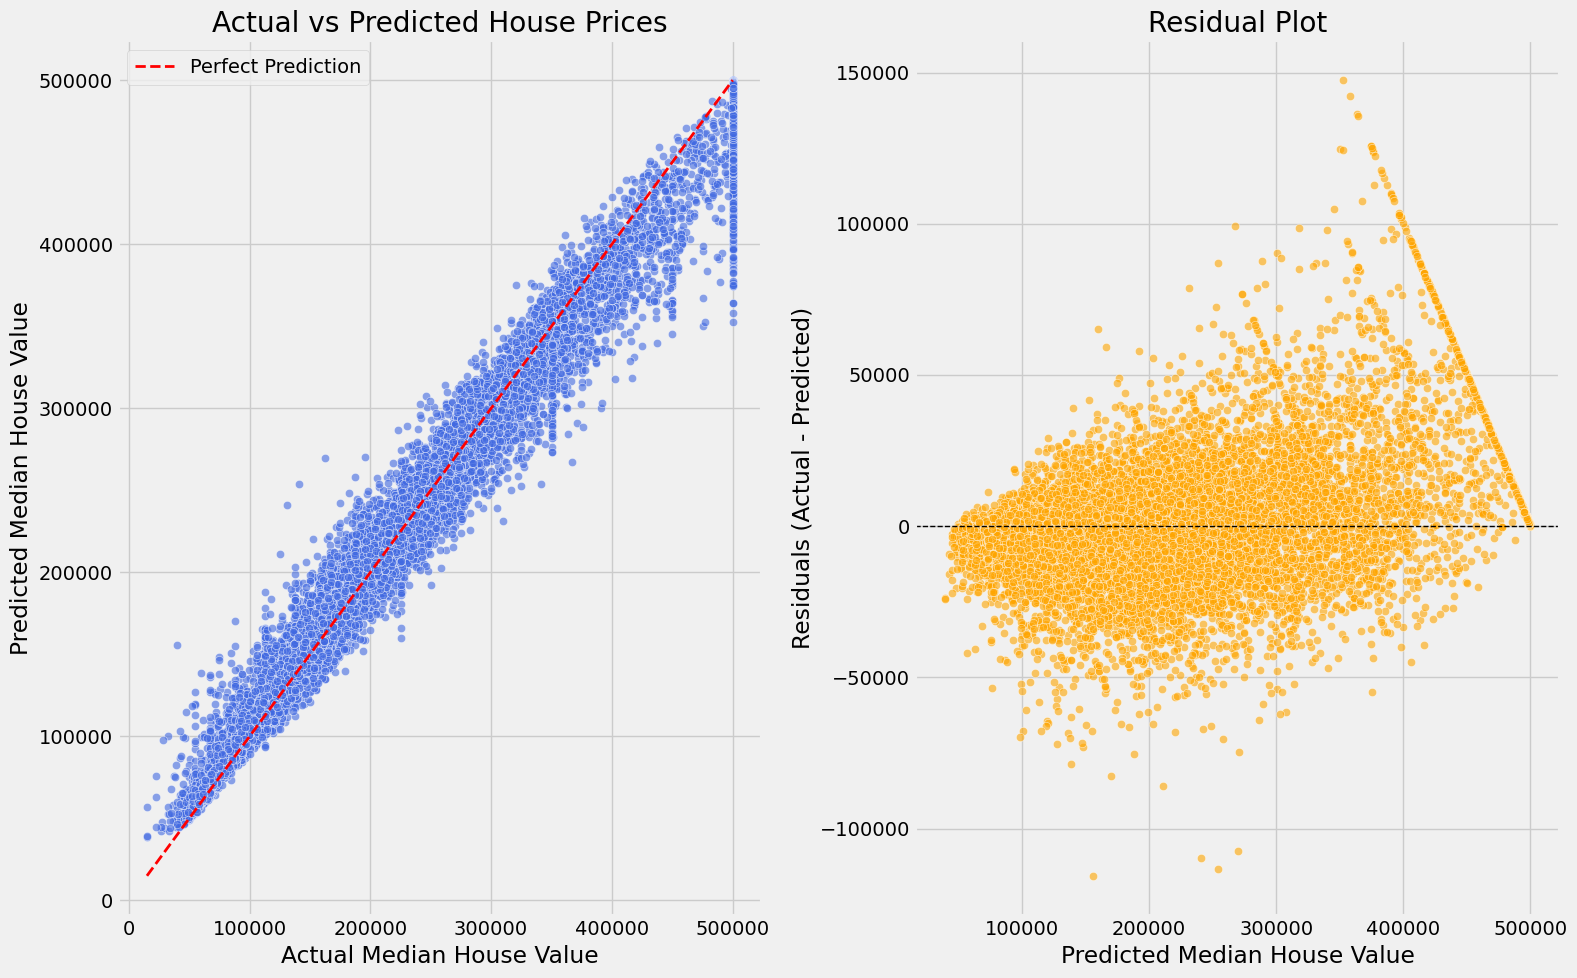

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(16, 10))

# --- Plot 1: Actual vs Predicted ---
plt.subplot(1, 2, 1)
sns.scatterplot(x=housing_labels, y=final_predictons, color='royalblue', alpha=0.6)

# Perfect prediction line
plt.plot(
    [housing_labels.min(), housing_labels.max()],
    [housing_labels.min(), housing_labels.max()],
    color='red', linestyle='--', linewidth=2, label='Perfect Prediction'
)

plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.grid(True)

# --- Plot 2: Residuals ---
residuals = housing_labels - final_predictons

plt.subplot(1, 2, 2)
sns.scatterplot(x=final_predictons, y=residuals, color='orange', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.xlabel("Predicted Median House Value")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('Actual vs Predicted House prices and Residual plot')

## 📈 Model Evaluation: Plot Interpretation

### ✅ Actual vs Predicted Plot
- Most predictions fall very close to the ideal red line (`y = x`), indicating strong accuracy.
- Minor underestimation is visible for high-priced houses, which is common in tree-based models like Random Forest.

### ✅ Residual Plot
- Residuals are randomly scattered around zero, showing that the model does not suffer from bias.
- No obvious trend, curve, or funnel pattern was observed, confirming that the model has captured most patterns in the data.
- Slight spread in residuals for higher predicted values reflects higher uncertainty in predicting expensive homes.

### ✅ Conclusion
The model demonstrates strong generalization and minimal bias. It's ready for further deployment or analysis.


## Plot the Feature Importance

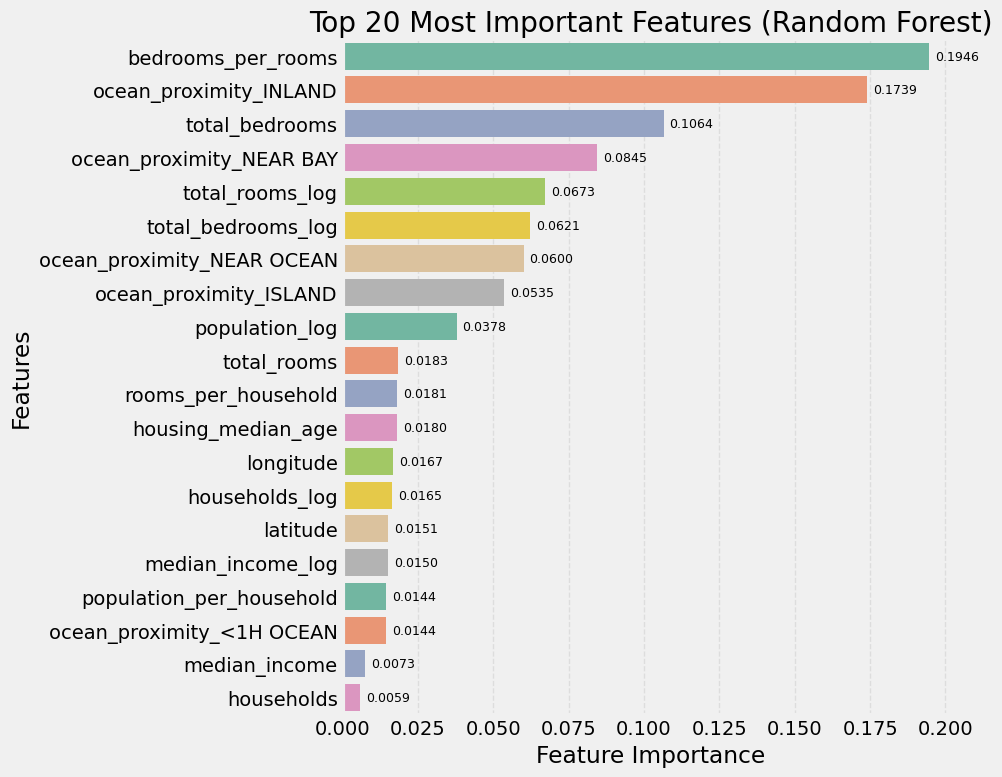

<Figure size 640x480 with 0 Axes>

In [32]:
# get featuer importance and column names
feature_importance = best_model.feature_importances_

# get feature names from final df `housing_df`
feature_names = housing_df.columns

# create the dataframe for visualizations
importance_df = pd.DataFrame({
    "Feature" : feature_names,
    "Importance":feature_importance
})

# sort values by Importance
importance_df = importance_df.sort_values(by='Importance',ascending=False)

# plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="Set2")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.grid(True,axis='x', linestyle='--', alpha=0.5)

# Add value labels
for i, v in enumerate(importance_df.head(20)["Importance"]):
    ax.text(v + 0.002, i, f"{v:.4f}", color='black', va='center', fontsize=9)
    
plt.show()
plt.savefig('Top 20 Most Important Features.png')

## 🧠 Feature Importance Insights (Random Forest)

Based on the Random Forest model's top 20 features, the following were identified as the most impactful:

1. **bedrooms_per_rooms** – The most important feature. This engineered ratio helps the model understand the **density or usage efficiency** of space in a home. A higher ratio could signal smaller, more segmented housing which may reduce value.
   
2. **ocean_proximity_INLAND** – The second most important feature. This confirms that **location matters a lot** — homes located inland follow different price trends compared to coastal areas.

3. **total_bedrooms** – This raw feature still plays a strong role in determining price. While it’s part of total room count, its standalone importance shows that **bedroom count affects desirability** and valuation.

4. **ocean_proximity_NEAR BAY** – Another one-hot encoded location indicator. Proximity to the bay increases house value, showing that **geographic context strongly influences pricing**.

5. **total_rooms_log** – A log-transformed version of the total room count. Using the **log scale reduces skewness** and helps the model better understand very large properties.

---

### ✅ Summary

- Smartly **engineered ratios** (`bedrooms_per_rooms`) are more informative than raw counts alone.
- **Location (ocean proximity)** continues to dominate real estate value prediction.
- **Log transformations** help manage skewed features like room counts.

This shows that **both domain knowledge and preprocessing choices (log, encoding, ratios)** significantly boosted model performance.


# ✅  Test Final Model on the Test Set

In [33]:
# Drop target and make copy
housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()

# Use full_pipeline used earlier
housing_test_prepared = full_pipeline.transform(housing_test)

# Predict with best model from RandomizedSearchCV
final_predictions = best_model.predict(housing_test_prepared)

# Evaluation metrics
mse = mean_squared_error(housing_test_labels, final_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(housing_test_labels, final_predictions)
r2 = r2_score(housing_test_labels, final_predictions)

# Print results
print("✅ Final Evaluation on Test Set:")
print(f"RMSE: {round(rmse, 2)}")
print(f"MAE : {round(mae, 2)}")
print(f"R²  : {round(r2, 4)}")

✅ Final Evaluation on Test Set:
RMSE: 49237.21
MAE : 33696.63
R²  : 0.814


### ✅ Final Model Evaluation on Test Set

After training and tuning the Random Forest model, we evaluated it on the unseen test set.

| Metric | Value |
|--------|--------|
| RMSE   | 49,237.21 |
| MAE    | 33,696.63 |
| R²     | 0.814 |

🔍 **Interpretation**:
- The model explains 81.4% of the variance in house prices.
- The typical prediction error is around ₹33,700.
- The results confirm that the model **generalizes well** to new data, though there is slight overfitting compared to the training performance (~97% R²).

✅ **Conclusion**:  
This model is suitable for practical use, reporting, or integration into a basic app or dashboard.


## Create the `predict_house_price()` Function

In [34]:
def predict_house_price(model, pipeline, input_data):
    """
    Predicts median house value using a trained model and pipeline.

    Parameters:
    -----------
    model : trained estimator (e.g. best_rf)
        The trained regression model
    pipeline : fitted preprocessing pipeline
        The ColumnTransformer + custom steps
    input_data : dict
        Dictionary with feature names and values

    Returns:
    --------
    price_prediction : float
        Predicted median house value
    """
    # Step 1: Convert input dict to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Step 2: Apply preprocessing
    prepared_data = pipeline.transform(input_df)
    
    # Step 3: Predict using the model
    prediction = model.predict(prepared_data)
    
    # Step 4: Return prediction rounded to 2 decimal places
    return round(prediction[0], 2)

# Example input (replace with actual values)
new_house = {
    'longitude': -122.23,
    'latitude': 37.88,
    'housing_median_age': 41.0,
    'total_rooms': 880.0,
    'total_bedrooms': 129.0,
    'population': 322.0,
    'households': 126.0,
    'median_income': 8.3252,
    'ocean_proximity': 'NEAR BAY'
}

# Predict the price
predicted_price = predict_house_price(best_model, full_pipeline, new_house)

print(f"🏠 Predicted Median House Value: ${predicted_price}")

🏠 Predicted Median House Value: $442269.18


## Save Final Tuned Model

In [35]:
import joblib
from custom_transformers import LogTransformer, CombinedAttributesAdder

joblib.dump(best_model, "final_random_forest_model.pkl")
joblib.dump(full_pipeline, "full_pipeline.pkl")


['full_pipeline.pkl']